In [29]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from skimage import io, transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from PIL import Image
import torchvision
from torchvision import models,transforms

from Dataloaders.HAM10000Dataset import HAM10000Dataset
from functions import normalization, Model_functions

import time

import random
from PIL import Image
import cv2
import gc

**Load and normalize the data**

In [2]:
data = pd.read_csv('data_enum.csv')
data = data.sample(frac=1)
img_h, img_w = 224, 224

In [3]:
# norm_means, norm_std = compute_img_mean_std(data['image_path'],img_h,img_w)

norm_means = [0.77148203, 0.55764165, 0.58345652]
norm_std = [0.12655577, 0.14245141, 0.15189891]

In [4]:
# define the transformation of the train images.
transform = transforms.Compose([transforms.Resize((img_h,img_w)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                        transforms.ToTensor(), transforms.Normalize(norm_means, norm_std)])
# define the transformation of the val and test images.
val_test_transform = transforms.Compose([transforms.Resize((img_h,img_w)), transforms.ToTensor(),
                                        transforms.Normalize(norm_means, norm_std)])

In [5]:
train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, val_data = train_test_split(train_val_data, test_size=0.5, random_state=42)

train_dataset = HAM10000Dataset(train_data, transform=transform)
val_dataset = HAM10000Dataset(val_data, transform=transform)
test_dataset = HAM10000Dataset(test_data, transform=transform)

In [6]:
batch_size = 32 
num_workers = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

print('Data len Train:', len(train_dataset), 'Val:', len(val_dataset), 'Test:', len(test_dataset))

Data len Train: 12362 Val: 12362 Test: 6181


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


# **MobileNet_v3**

In [8]:
model_temp = 'mobilenet_v3'
feature_extract = False
num_classes = 7
model_res = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_res.to(device)

/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [9]:
input_size = (3, 224, 224)
print(summary(model_res, input_size, device=device.type))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 960, 7, 7]           --
|    └─Conv2dNormActivation: 2-1                   [-1, 16, 112, 112]        --
|    |    └─Conv2d: 3-1                            [-1, 16, 112, 112]        432
|    |    └─BatchNorm2d: 3-2                       [-1, 16, 112, 112]        32
|    |    └─Hardswish: 3-3                         [-1, 16, 112, 112]        --
|    └─InvertedResidual: 2-2                       [-1, 16, 112, 112]        --
|    |    └─Sequential: 3-4                        [-1, 16, 112, 112]        464
|    └─InvertedResidual: 2-3                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-5                        [-1, 24, 56, 56]          3,440
|    └─InvertedResidual: 2-4                       [-1, 24, 56, 56]          --
|    |    └─Sequential: 3-6                        [-1, 24, 56, 56]          4,440
|    └─InvertedResidual: 2-

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_res.parameters(), lr=1e-3)

In [11]:
start_time = time.time()

In [12]:
epochs = 5 
patience = 5
model_filename = 'mobilenetv3_pret.pth'
resnet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_res, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

 20%|██        | 1/5 [02:04<08:19, 124.84s/it]

Epoch 1
Training Loss: 0.6040532044123001 
Training Accuracy: 78.13460605080084%
Validation Loss: 0.7671703584203424 
Validation Accuracy: 74.87461575796797%
Validation Loss Decreased(inf--->0.767170) 
Saving The Model


 40%|████      | 2/5 [04:09<06:13, 124.63s/it]

Epoch 2
Training Loss: 0.34467587157968405 
Training Accuracy: 88.07636304805048%
Validation Loss: 0.4271562077605601 
Validation Accuracy: 85.56058890147226%
Validation Loss Decreased(0.767170--->0.427156) 
Saving The Model


 60%|██████    | 3/5 [06:05<04:01, 120.65s/it]

Epoch 3
Training Loss: 0.26797514267564204 
Training Accuracy: 90.78628053712991%
Validation Loss: 0.4358049654895175 
Validation Accuracy: 86.67691312085424%


 80%|████████  | 4/5 [08:10<02:02, 122.38s/it]

Epoch 4
Training Loss: 0.20202344417263987 
Training Accuracy: 93.15644717683223%
Validation Loss: 0.16532784259399202 
Validation Accuracy: 94.70150461090438%
Validation Loss Decreased(0.427156--->0.165328) 
Saving The Model


100%|██████████| 5/5 [10:05<00:00, 121.12s/it]

Epoch 5
Training Loss: 0.17515391008615572 
Training Accuracy: 93.86021679339913%
Validation Loss: 0.1142324826082104 
Validation Accuracy: 96.2870085746643%
Validation Loss Decreased(0.165328--->0.114232) 
Saving The Model


In [13]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for the Resnet Pretrainned Model: {total_time/60:.2f} minutes")
elapsed_time = end_time - start_time

Total training and validation time for the Resnet Pretrainned Model: 10.09 minutes


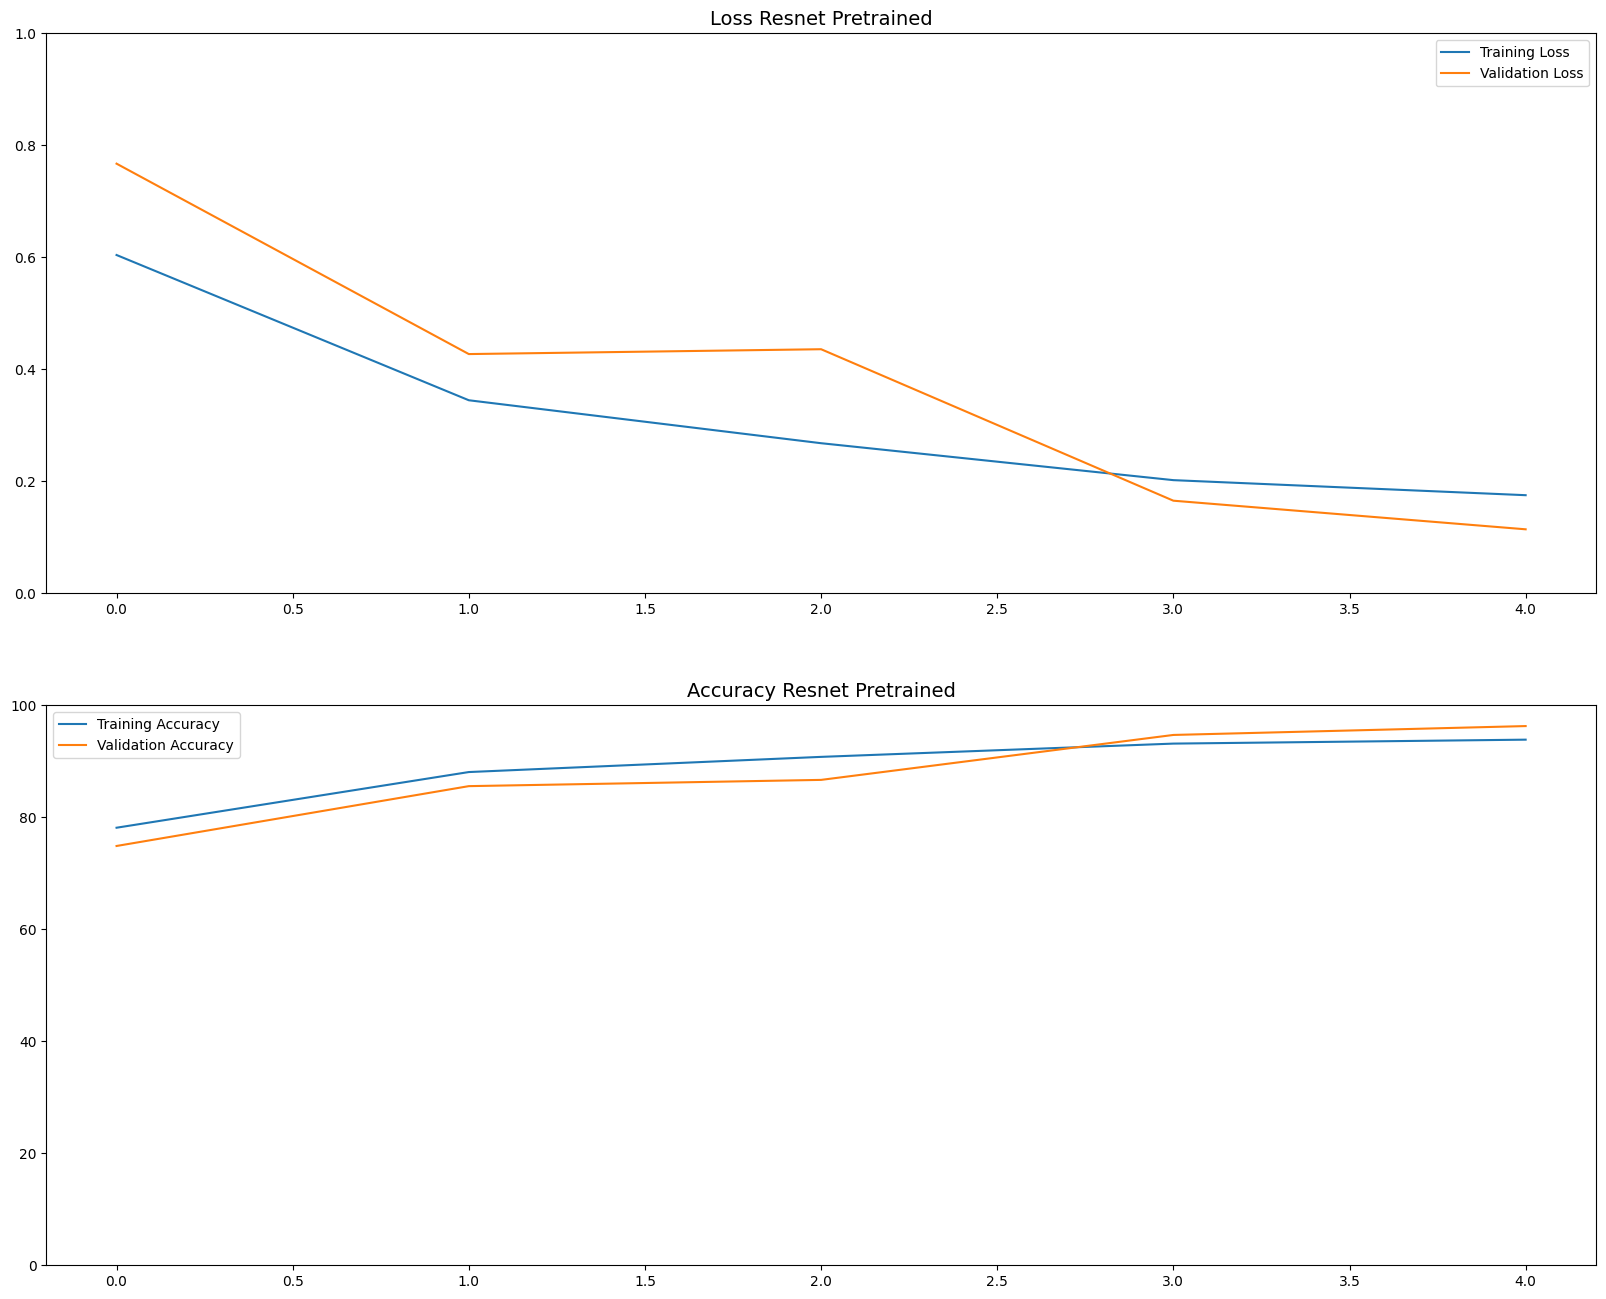

In [14]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_title('Loss Resnet Pretrained', fontsize=14)  
fig1.set_ylim([0, 1])
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy Resnet Pretrained', fontsize=14)  
fig2.legend()
plt.show()

In [15]:
start_time = time.time()
best_model_state = torch.load('mobilenetv3_pret.pth', map_location='cpu')
model_res.load_state_dict(best_model_state)
model_res.to('cpu')  
device = torch.device('cpu')
test_accuracy = Model_functions.test_model(model_res, test_loader, device)

infer_time = time.time() - start_time
print('-------------------------------------------------------')
print(f'Best model\'s accuracy: {test_accuracy}')
print(len(test_loader) , infer_time)
print('-------------------------------------------------------')


-------------------------------------------------------
Best model's accuracy: 96.61867011810386
194 42.39114594459534
-------------------------------------------------------


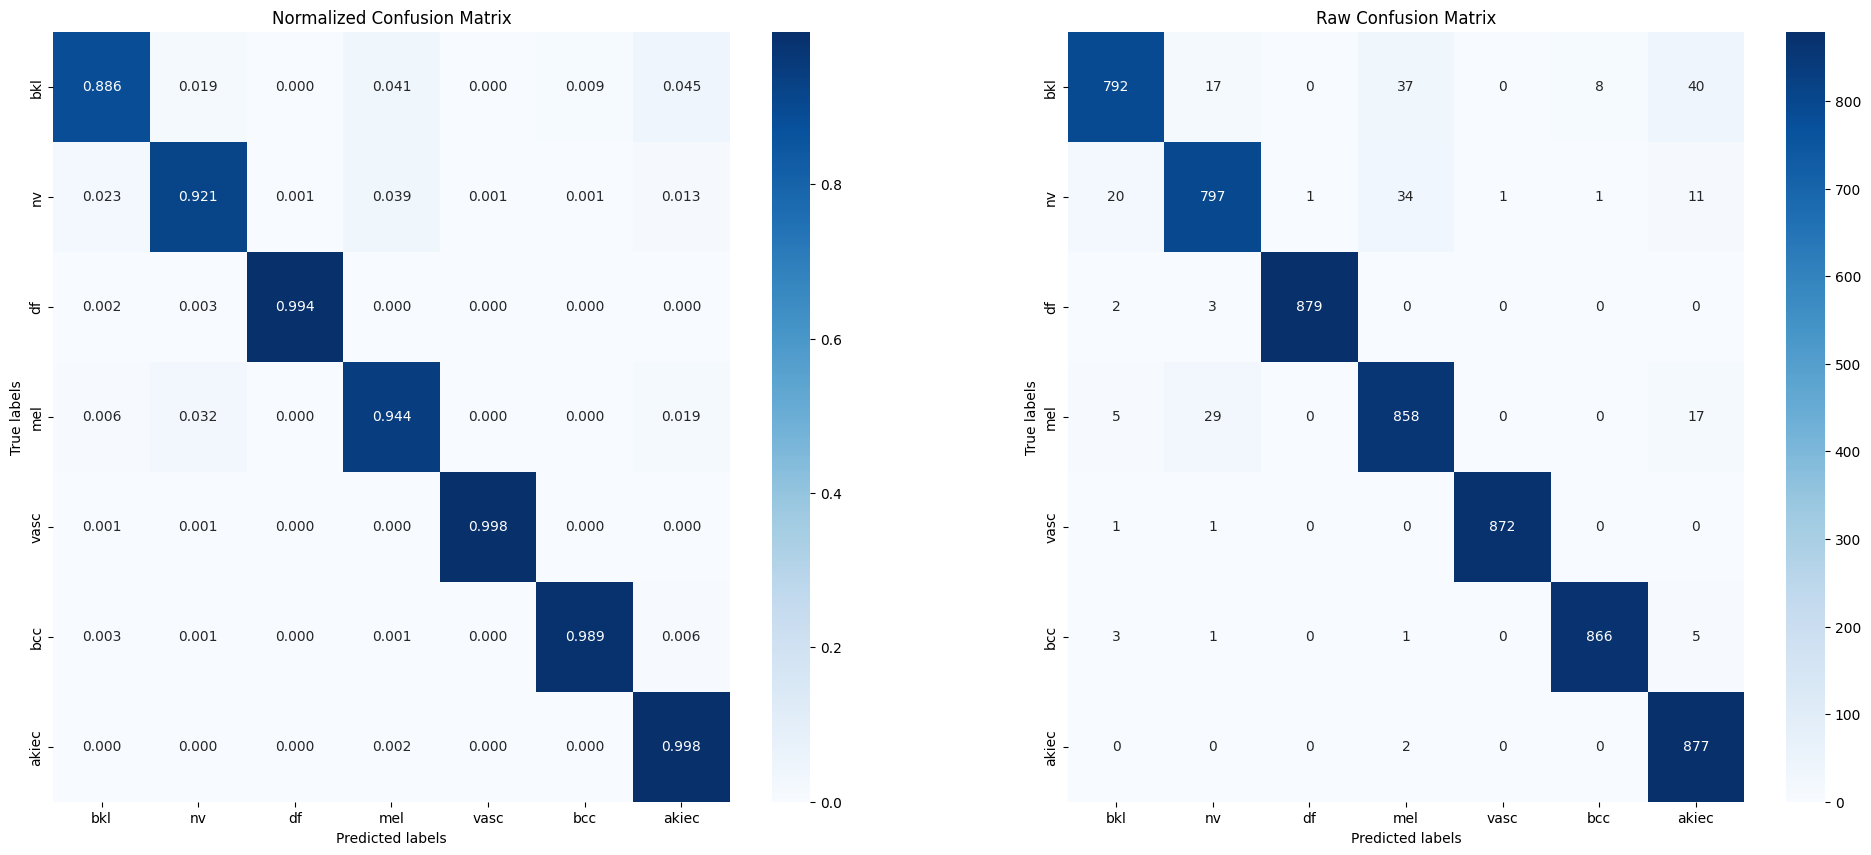

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.96      0.89      0.92       894
          nv       0.94      0.92      0.93       865
          df       1.00      0.99      1.00       884
         mel       0.92      0.94      0.93       909
        vasc       1.00      1.00      1.00       874
         bcc       0.99      0.99      0.99       876
       akiec       0.92      1.00      0.96       879

    accuracy                           0.96      6181
   macro avg       0.96      0.96      0.96      6181
weighted avg       0.96      0.96      0.96      6181

-------------------------------------------------------


In [16]:
Model_functions.conf_report(model_res, test_loader, 'mobilenet_conf_mat')

**Empty the CUDA memory**

In [17]:
torch.cuda.empty_cache() 
gc.collect()

15668

In [18]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

# **Effecient Net**

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [20]:
model_temp = 'effiecentnet'
num_classes = 7
feature_extract = False
model_des = Model_functions.initialise_model(model_temp, num_classes, feature_extract, use_pretrained=True)
model_des.to(device)

/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/DNN/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [21]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model_des.parameters(), lr=1e-3)

In [22]:
input_size = (3, 224, 224)
print(summary(model_des, input_size, device=device.type))

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 1792, 7, 7]          --
|    └─Conv2dNormActivation: 2-1              [-1, 48, 112, 112]        --
|    |    └─Conv2d: 3-1                       [-1, 48, 112, 112]        1,296
|    |    └─BatchNorm2d: 3-2                  [-1, 48, 112, 112]        96
|    |    └─SiLU: 3-3                         [-1, 48, 112, 112]        --
|    └─Sequential: 2-2                        [-1, 24, 112, 112]        --
|    |    └─MBConv: 3-4                       [-1, 24, 112, 112]        2,940
|    |    └─MBConv: 3-5                       [-1, 24, 112, 112]        1,206
|    └─Sequential: 2-3                        [-1, 32, 56, 56]          --
|    |    └─MBConv: 3-6                       [-1, 32, 56, 56]          11,878
|    |    └─MBConv: 3-7                       [-1, 32, 56, 56]          18,120
|    |    └─MBConv: 3-8                       [-1, 32, 56, 56]          18,120

In [23]:
start_time = time.time()

In [24]:
epochs = 2 
patience = 5
model_filename = 'effiecentnet.pth'
densenet_model, total_loss_train, total_loss_val, total_acc_train, total_acc_val = Model_functions.train_and_validate_model(
                        model_des, train_loader, val_loader,test_loader, criterion,patience, optimizer, device, epochs, model_filename,verbose=True)

 50%|█████     | 1/2 [01:55<01:55, 115.27s/it]

Epoch 1
Training Loss: 0.5589771223969238 
Training Accuracy: 79.79291376799871%
Validation Loss: 0.2112919887195724 
Validation Accuracy: 92.45267756026533%
Validation Loss Decreased(inf--->0.211292) 
Saving The Model


100%|██████████| 2/2 [03:49<00:00, 114.52s/it]

Epoch 2
Training Loss: 0.20458004796680168 
Training Accuracy: 92.92994661058081%
Validation Loss: 0.13134432493201254 
Validation Accuracy: 95.680310629348%
Validation Loss Decreased(0.211292--->0.131344) 
Saving The Model


In [25]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total training and validation time for Pretrainned Densenet model: {total_time/60:.2f} minutes")

Total training and validation time for Pretrainned Densenet model: 3.82 minutes


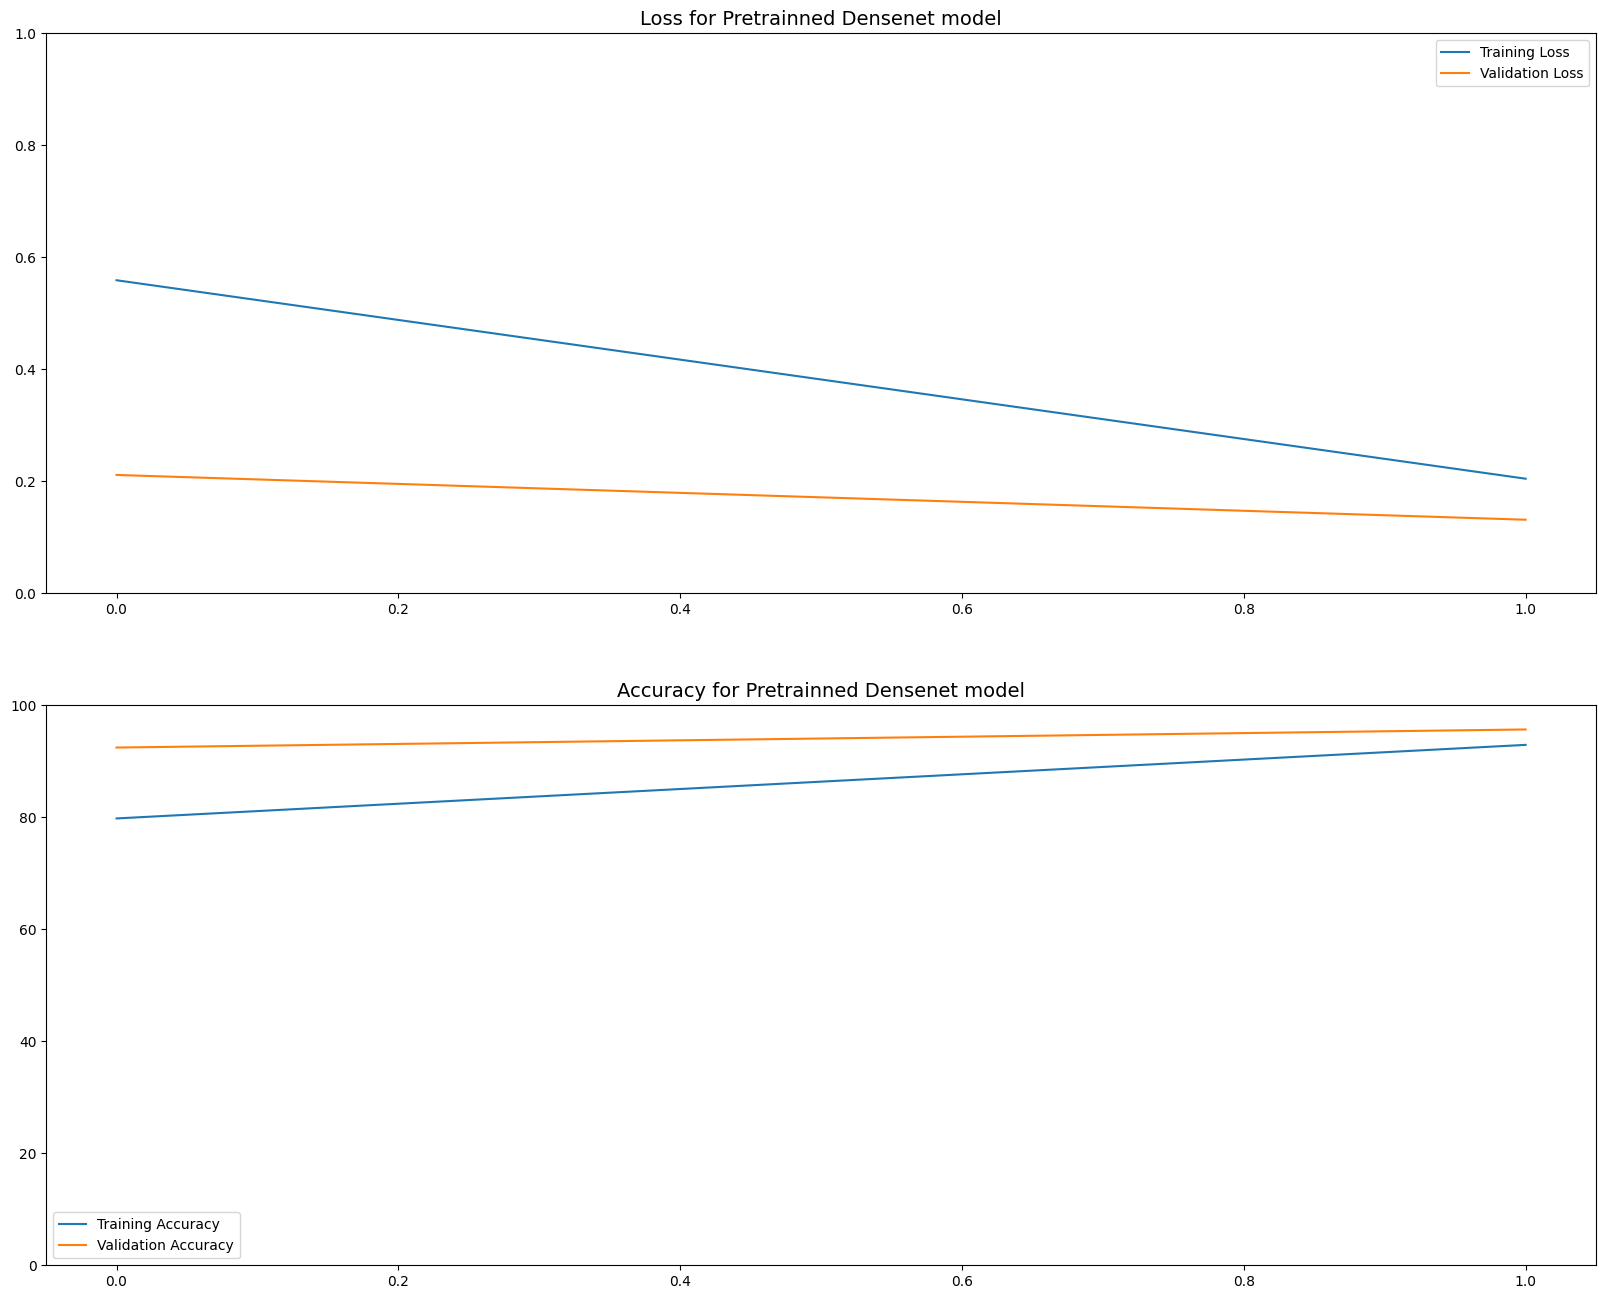

In [26]:
fig = plt.figure(num=2, figsize=(20, 16))  
fig1 = fig.add_subplot(2, 1, 1)
fig2 = fig.add_subplot(2, 1, 2)

fig1.plot(total_loss_train, label='Training Loss')
fig1.plot(total_loss_val, label='Validation Loss')
fig1.set_ylim([0, 1])
fig1.set_title('Loss for Pretrainned Densenet model', fontsize=14)  
fig1.legend()
fig2.plot(total_acc_train, label='Training Accuracy')
fig2.plot(total_acc_val, label='Validation Accuracy')
fig2.set_ylim([0, 100])
fig2.set_title('Accuracy for Pretrainned Densenet model', fontsize=14)  
fig2.legend()
plt.show()

In [27]:
best_model_state = torch.load('effiecentnet.pth',map_location='cpu')
device = torch.device('cpu')
model_des.load_state_dict(best_model_state)
model_des.to(device)

start_time = time.time()
test_accuracy = Model_functions.test_model(model_des, test_loader, device)
infer_time = time.time() - start_time
print('-------------------------------------------------------')
print(f'Best models accuracy {test_accuracy}')
print(len(test_loader),infer_time)
print('-------------------------------------------------------')

-------------------------------------------------------
Best models accuracy 95.7288464649733
194 57.69697618484497
-------------------------------------------------------


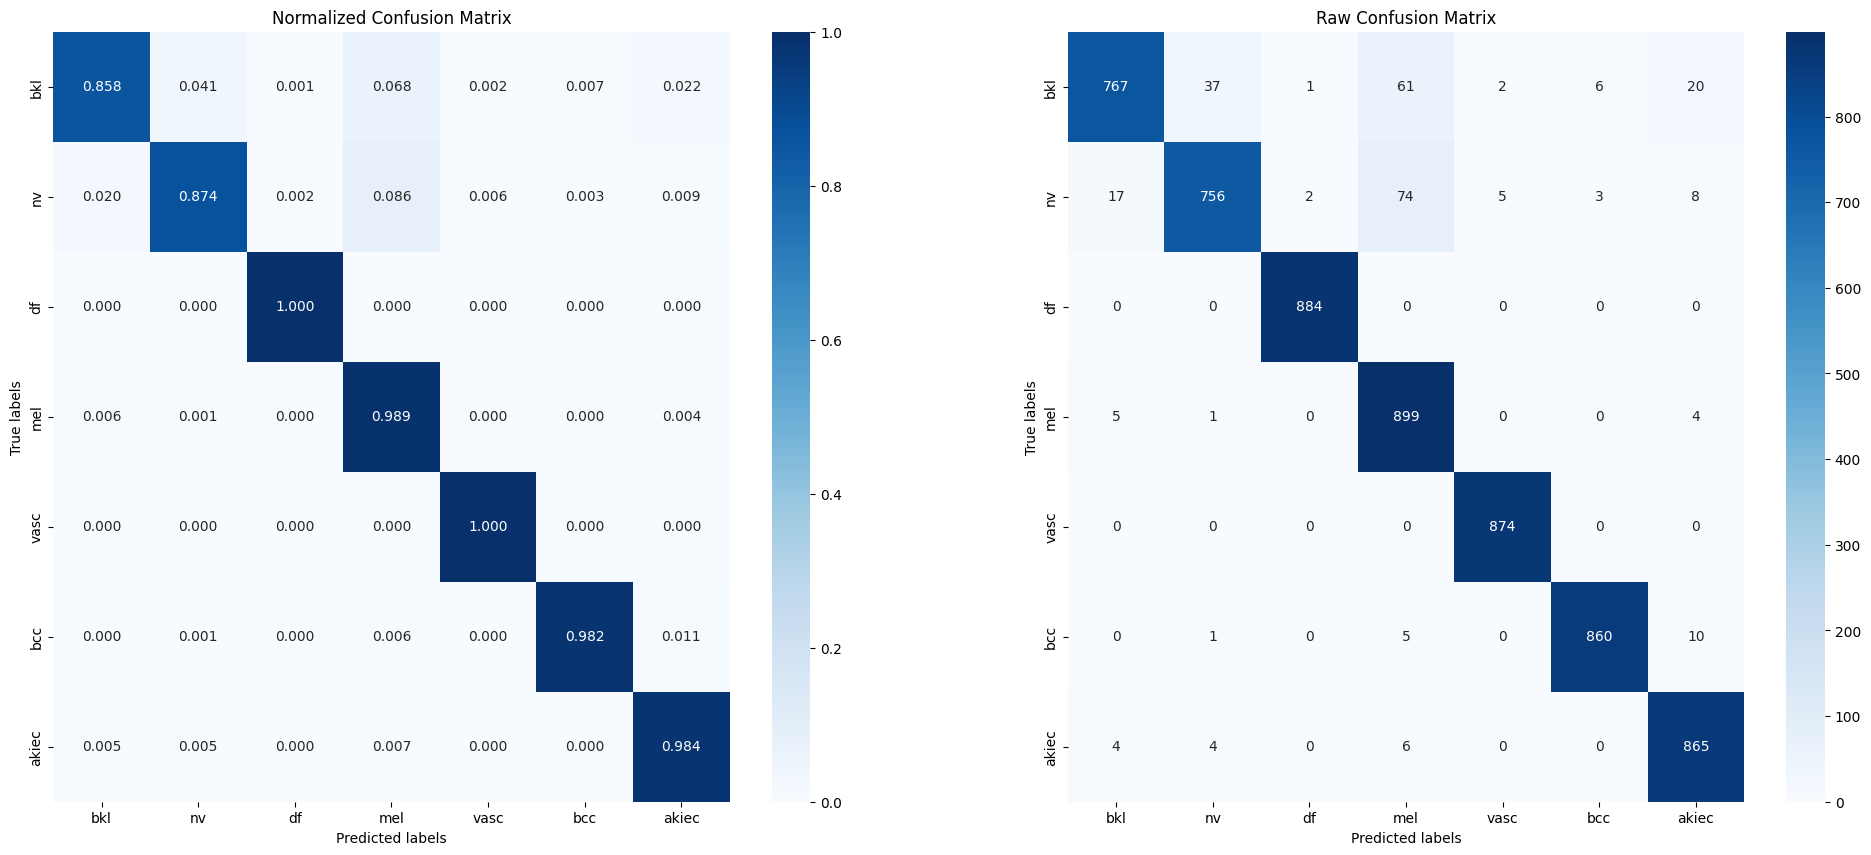

-------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

         bkl       0.97      0.86      0.91       894
          nv       0.95      0.87      0.91       865
          df       1.00      1.00      1.00       884
         mel       0.86      0.99      0.92       909
        vasc       0.99      1.00      1.00       874
         bcc       0.99      0.98      0.99       876
       akiec       0.95      0.98      0.97       879

    accuracy                           0.96      6181
   macro avg       0.96      0.96      0.96      6181
weighted avg       0.96      0.96      0.96      6181

-------------------------------------------------------


In [28]:
Model_functions.conf_report(model_des, test_loader, 'efficentnet_conf_mat')